# Groundtruth training on focused edges (training 1)

In [1]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

<IPython.core.display.Javascript object>

## Presentation

For each different training we proceed as follow:

Step 1: random search or bayesian search over a lot of models and parameters\
Step 2: evaluate the 3 best models with cross validation and chose the best out of the 3

For the seed, we always take the same seed: 100

## Setup

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import imageio

from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import keras_tuner as kt

from amftrack.ml.width.models import hyper_model_builder_simple, build_model_dense, build_model_conv
from amftrack.util.sys import storage_path
from amftrack.ml.width.data_augmentation import data_augmentation, data_preparation
from keras.utils.layer_utils import count_params  

### Fetch data

Repository with all possible datasets

In [20]:
dataset_path = os.path.join(storage_path, "datasets")

Two datasets that I have choosen to use

In [21]:
focused_dataset_path = os.path.join(dataset_path, "focused_with_varying_lum_train") # dataset with varying lumination but consistent focus
extended_dataset_path = os.path.join(dataset_path, "varying_lum_and_focus_train") # dataset with varying lumination but consistent focus

For now: using the focused dataset

In [22]:
path = focused_dataset_path

In [23]:
im_path = os.path.join(path, "slices.png")
label_path = os.path.join(path, "labels.npy")

In [24]:
im = imageio.imread(im_path)
print(im.shape)

(527, 120)


In [25]:
with open(label_path, 'rb') as f:
    label = np.load(f)
print(label.shape)

(527,)


In [26]:
label = np.expand_dims(label, axis = 1)

In [27]:
label.shape

(527, 1)

### Data preparation

For seperating the test set (not used for now as the test is done in another notebook²)

In [28]:
seed = 11
np.random.seed(11)
p = np.random.permutation(len(label))
training = p[:-150]
valid = p[-150:]
print(len(training))
print(len(valid))

377
150


In [29]:
train_feature = im[training, :]
train_label = label[training,:]
valid_feature = im[valid, :]
valid_label = label[valid, :]

Instead we just take it all

In [30]:
train_feature.shape

(377, 120)

### Visualisation

In [13]:
i = 300

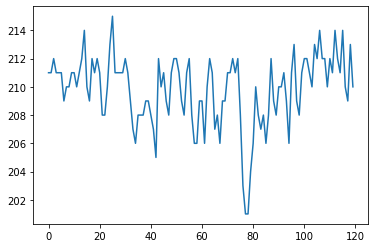

In [14]:
plt.plot(im[i,:])

In [327]:
label[i,:]

array([3.54463004])

## Mean predicting model

In [15]:
train_label.shape

(377, 1)

In [16]:
np.var(train_label)

4.982430809438182

In [17]:
np.std(train_label)

2.2321359298748322

In [18]:
mean = np.mean(train_label)
pred = np.full(train_label.shape, mean)
res = np.mean((train_label - pred)**2)
print(f"Mean is: {mean}, Mean squarred error is: {res}")

Mean is: 5.279759580329631, Mean squarred error is: 4.982430809438182


In [19]:
mean = np.mean(train_label)
pred = np.full(train_label.shape, mean)
res = np.mean(abs(train_label - pred))
print(f"Mean is: {mean}, Mean absolute error is: {res}")

Mean is: 5.279759580329631, Mean absolute error is: 1.5887181524020357


## Data preprocessing

### Train dataset

In [83]:
from amftrack.ml.width.data_augmentation import data_preparation, data_augmentation, random_crop, random_mirror, random_invert, random_brightness

In [84]:
train_feature.shape

(211, 120)

PROPRE

In [85]:
train_feature_ds = np.expand_dims(train_feature, axis = -1)
train_feature_ds = np.expand_dims(train_feature_ds, axis = -3)

In [86]:
train_feature_ds.shape

(211, 1, 120, 1)

In [87]:
d1 = tf.data.Dataset.from_tensor_slices(train_feature_ds)
d2 = tf.data.Dataset.from_tensor_slices(train_label)
train_ds = tf.data.Dataset.zip((d1, d2))

In [88]:
# TEST
d1

<TensorSliceDataset element_spec=TensorSpec(shape=(1, 120, 1), dtype=tf.uint8, name=None)>

In [89]:
# TEST
d2

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float64, name=None)>

In [90]:
# TEST
train_label.shape

(211, 1)

In [91]:
# TEST
for e in train_ds:
    break
data_augmentation(e[0])

<tf.Tensor: shape=(1, 80, 1), dtype=float32, numpy=
array([[[141.],
        [141.],
        [144.],
        [145.],
        [144.],
        [144.],
        [144.],
        [141.],
        [144.],
        [143.],
        [141.],
        [142.],
        [144.],
        [143.],
        [143.],
        [142.],
        [141.],
        [142.],
        [144.],
        [144.],
        [144.],
        [145.],
        [144.],
        [143.],
        [143.],
        [145.],
        [145.],
        [143.],
        [146.],
        [145.],
        [145.],
        [144.],
        [143.],
        [144.],
        [138.],
        [133.],
        [120.],
        [111.],
        [102.],
        [103.],
        [113.],
        [119.],
        [118.],
        [120.],
        [124.],
        [123.],
        [123.],
        [124.],
        [123.],
        [124.],
        [124.],
        [126.],
        [124.],
        [126.],
        [128.],
        [129.],
        [129.],
        [134.],
        [133.],
    

In [92]:
train_ds = (
    train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
    #.unbatch()
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

In [93]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

TEST

In [31]:
for e in train_ds:
    break

In [32]:
np.array(e[0]).shape

(16, 1, 80, 1)

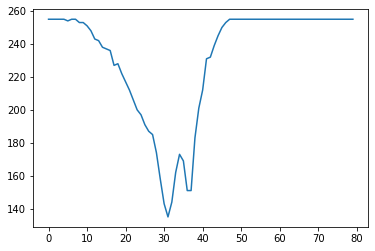

In [33]:
plt.plot(np.array(e[0][0, 0,:,0]))

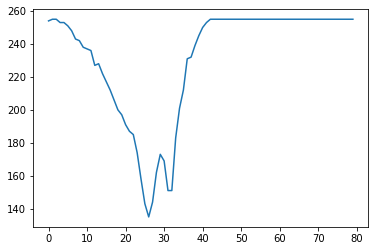

In [119]:
plt.plot(np.array(e[0][0,:,0]))

### Test dataset

In [106]:
valid_feature_ds = np.expand_dims(valid_feature, axis = -1)
valid_feature_ds = np.expand_dims(valid_feature_ds, axis = -3)
d1 = tf.data.Dataset.from_tensor_slices(valid_feature_ds)
d2 = tf.data.Dataset.from_tensor_slices(valid_label)
valid_ds = tf.data.Dataset.zip((d1, d2))
valid_ds = (
    valid_ds.map(lambda x, y: (data_preparation(x, training=True), y))
    .unbatch()
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

In [107]:
for e in valid_ds:
    print(e)
    break

(<tf.Tensor: shape=(16, 80, 1), dtype=float32, numpy=
array([[[131.],
        [130.],
        [129.],
        ...,
        [126.],
        [124.],
        [125.]],

       [[130.],
        [130.],
        [128.],
        ...,
        [125.],
        [124.],
        [126.]],

       [[130.],
        [131.],
        [131.],
        ...,
        [125.],
        [125.],
        [126.]],

       ...,

       [[134.],
        [133.],
        [134.],
        ...,
        [130.],
        [131.],
        [130.]],

       [[123.],
        [121.],
        [123.],
        ...,
        [115.],
        [117.],
        [116.]],

       [[114.],
        [113.],
        [117.],
        ...,
        [110.],
        [113.],
        [114.]]], dtype=float32)>, <tf.Tensor: shape=(16,), dtype=float64, numpy=
array([7.26221294, 5.93755418, 5.5774322 , 4.19787153, 3.7441611 ,
       5.20109506, 4.87914297, 0.        , 8.52101685, 8.73503977,
       4.59109883, 4.34090199, 4.35067225, 4.18356936, 5.923182  ,
  

## Training a dense model

### 1/ Run hyperparameter search

In [108]:
tuner = kt.RandomSearch(
    build_model_dense,
    objective='val_mean_absolute_error',
    max_trials=2,
    seed=seed,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    overwrite=True
)

Without augmentation:

Actual search

In [109]:
tuner.search(train_ds,
             validation_data= valid_ds,
             epochs=100,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=8)])

Trial 2 Complete [00h 00m 09s]
val_mean_absolute_error: 1.5756679773330688

Best val_mean_absolute_error So Far: 1.170708417892456
Total elapsed time: 00h 00m 27s
INFO:tensorflow:Oracle triggered exit
2022-08-17 16:31:11,773-[INFO]- tensorflow:1 -> Oracle triggered exit


### 2/ Analyse hyperparameter search results

#### Search space

In [132]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
input_size (Fixed)
{'conditions': [], 'value': 80}
hidden_size (Int)
{'default': 32, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 32, 'sampling': None}
regul (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
dense_blocks (Int)
{'default': 3, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': None}
dropout (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


#### Best models

In [133]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
input_size: 80
hidden_size: 42
regul: 0.0035557261842639634
dense_blocks: 3
dropout: 0.0
learning_rate: 0.0016003804865801434
Score: 0.8687390089035034
Trial summary
Hyperparameters:
input_size: 80
hidden_size: 74
regul: 0.0014215854798312684
dense_blocks: 4
dropout: 0.0
learning_rate: 0.0009024056738718249
Score: 0.8745074272155762
Trial summary
Hyperparameters:
input_size: 80
hidden_size: 74
regul: 0.003042708823781575
dense_blocks: 10
dropout: 0.0
learning_rate: 0.00012991522868696756
Score: 0.893924355506897
Trial summary
Hyperparameters:
input_size: 80
hidden_size: 42
regul: 2.3894475848953514e-05
dense_blocks: 2
dropout: 0.1
learning_rate: 0.005474312018433092
Score: 0.8982808589935303
Trial summary
Hyperparameters:
input_size: 80
hidden_size: 42
regul: 0.005345868140133228
dense_blocks: 7
dropout: 0.1
learning_rate: 0.0006830096465894109
Score: 0.8991726636886597
Trial summary
Hyp

In [134]:
best_models = tuner.get_best_models(10)

In [137]:
best_parameters = tuner.get_best_hyperparameters(10)

In [155]:
dir(tuner)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_and_fit_model',
 '_build_hypermodel',
 '_configure_tensorboard_dir',
 '_deepcopy_callbacks',
 '_display',
 '_get_checkpoint_fname',
 '_get_tensorboard_dir',
 '_get_tuner_fname',
 '_override_compile_args',
 '_populate_initial_space',
 '_save_n_checkpoints',
 '_try_build',
 'directory',
 'distribution_strategy',
 'executions_per_trial',
 'get_best_hyperparameters',
 'get_best_models',
 'get_state',
 'get_trial_dir',
 'hypermodel',
 'load_model',
 'logger',
 'loss',
 'max_model_size',
 'metrics',
 'on_batch_begin',
 'on_batch_end',
 'on_epoch_begin',
 'on_epoch_end',
 'on_search_begin',
 'on_search_end',
 'on_trial_b

#### Best model

In [135]:
best_model = best_models[0]

In [136]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 1)]           0         
                                                                 
 reshape (Reshape)           (None, 80)                0         
                                                                 
 rescaling (Rescaling)       (None, 80)                0         
                                                                 
 dense (Dense)               (None, 42)                3402      
                                                                 
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense_1 (Dense)             (None, 42)                1806      
                                                                 
 dropout_1 (Dropout)         (None, 42)                0     

In [143]:
best_hyperparameters = best_parameters[0]
best_hyperparameters.values

{'input_size': 80,
 'hidden_size': 42,
 'regul': 0.0035557261842639634,
 'dense_blocks': 3,
 'dropout': 0.0,
 'learning_rate': 0.0016003804865801434}

In [ ]:
best_hyperparmeters[i][]

In [154]:

for i in range(10):
    print(f"Model {i}")
    print(count_params(best_models[i].trainable_weights))
    print()

Model 0
7057
Model 1
22719
Model 2
56019
Model 3
5251
Model 4
14281
Model 5
8863
Model 6
17169
Model 7
11619
Model 8
17169
Model 9
7057


#### Visualize prediction on the validation set

In [156]:
def plot_against(model, test_feature, test_label):
    predicted = model.predict(test_feature)
    plt.scatter(test_label, predicted, marker='o')
    plt.plot([0,12],[0,12])
    plt.xlim(2, 16)
    plt.ylim(2, 16)

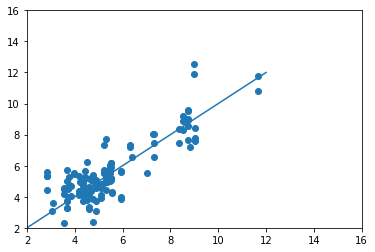

In [157]:
plot_against(best_model, data_preparation(valid_feature), valid_label)

In [158]:
best_model.evaluate(data_preparation(valid_feature), valid_label)

5/5 [==============================] - 0s 963us/step - loss: 2.5229 - mean_absolute_error: 0.8687


[2.522871255874634, 0.8687390089035034]

In [159]:
valid_feature.shape

(150, 120)

### 3/ Retrain the best models with cross validation

valid_e is the validation set for early stopping\
valid is the validation set to evaluate a split

**Model**

In [31]:
hp = kt.HyperParameters()
hp.Fixed('hidden_size', 42)
hp.Fixed('regul', 0.0035)
hp.Fixed('dense_blocks', 3)
hp.Fixed('dropout', 0.0)
hp.Fixed('learning_rate', 0.0016)
new_model = build_model_dense(hp)

In [32]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 80, 1)]           0         
                                                                 
 reshape_1 (Reshape)         (None, 80)                0         
                                                                 
 rescaling_1 (Rescaling)     (None, 80)                0         
                                                                 
 dense_4 (Dense)             (None, 42)                3402      
                                                                 
 dropout_3 (Dropout)         (None, 42)                0         
                                                                 
 dense_5 (Dense)             (None, 42)                1806      
                                                                 
 dropout_4 (Dropout)         (None, 42)                0   

TEST

In [129]:
train_feature_ds = np.expand_dims(train_feature, axis = -1)
train_feature_ds = np.expand_dims(train_feature_ds, axis = -3)
d1 = tf.data.Dataset.from_tensor_slices(train_feature_ds)
d2 = tf.data.Dataset.from_tensor_slices(train_label)
train_ds = tf.data.Dataset.zip((d1, d2))
train_ds = (
    train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
    .unbatch()
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

In [130]:
valid_feature_ds = np.expand_dims(valid_feature, axis = -1)
valid_feature_ds = np.expand_dims(valid_feature_ds, axis = -3)
d1 = tf.data.Dataset.from_tensor_slices(valid_feature_ds)
d2 = tf.data.Dataset.from_tensor_slices(valid_label)
valid_ds = tf.data.Dataset.zip((d1, d2))
valid_ds = (
    valid_ds.map(lambda x, y: (data_preparation(x, training=True), y))
    .unbatch()
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

In [131]:
valid_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 80, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [132]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [133]:
new_model.fit(train_ds,
             validation_data= valid_ds,
             epochs=10,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=8)])

Epoch 1/10
14/14 [==============================] - 0s 3ms/step - loss: 4.6600 - mean_absolute_error: 1.0543 - val_loss: 4.0991 - val_mean_absolute_error: 0.9275
Epoch 2/10
14/14 [==============================] - 0s 3ms/step - loss: 4.6988 - mean_absolute_error: 1.0768 - val_loss: 4.1338 - val_mean_absolute_error: 0.9331
Epoch 3/10
14/14 [==============================] - 0s 3ms/step - loss: 4.4657 - mean_absolute_error: 1.0580 - val_loss: 4.1469 - val_mean_absolute_error: 0.9348
Epoch 4/10
14/14 [==============================] - 0s 3ms/step - loss: 4.4898 - mean_absolute_error: 1.0249 - val_loss: 4.1389 - val_mean_absolute_error: 0.9331
Epoch 5/10
14/14 [==============================] - 0s 3ms/step - loss: 4.7235 - mean_absolute_error: 1.0353 - val_loss: 4.1390 - val_mean_absolute_error: 0.9335
Epoch 6/10
14/14 [==============================] - 0s 3ms/step - loss: 4.5305 - mean_absolute_error: 1.0230 - val_loss: 4.1320 - val_mean_absolute_error: 0.9347
Epoch 7/10
14/14 [==========

In [125]:
new_model.fit(train_ds,
             #validation_data= valid_ds,
             epochs=10)
             #callbacks=[tf.keras.callbacks.EarlyStopping(patience=8)])

Epoch 1/10
14/14 [==============================] - 0s 1ms/step - loss: 4.5037 - mean_absolute_error: 0.9856
Epoch 2/10
14/14 [==============================] - 0s 1ms/step - loss: 4.4326 - mean_absolute_error: 0.9758
Epoch 3/10
14/14 [==============================] - 0s 1ms/step - loss: 4.3715 - mean_absolute_error: 0.9688
Epoch 4/10
14/14 [==============================] - 0s 1ms/step - loss: 4.3187 - mean_absolute_error: 0.9627
Epoch 5/10
14/14 [==============================] - 0s 1ms/step - loss: 4.2734 - mean_absolute_error: 0.9568
Epoch 6/10
14/14 [==============================] - 0s 1ms/step - loss: 4.2340 - mean_absolute_error: 0.9511
Epoch 7/10
14/14 [==============================] - 0s 2ms/step - loss: 4.1989 - mean_absolute_error: 0.9458
Epoch 8/10
14/14 [==============================] - 0s 1ms/step - loss: 4.1681 - mean_absolute_error: 0.9407
Epoch 9/10
14/14 [==============================] - 0s 1ms/step - loss: 4.1401 - mean_absolute_error: 0.9354
Epoch 10/10
14/14 [

In [98]:
new_model.fit(train_ds,
             validation_data= valid_ds,
             epochs=100,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=8)])

Epoch 1/100
    204/Unknown - 0s 997us/step - loss: 25.8399 - mean_absolute_error: 4.2151

ValueError: in user code:

    File "/home/ipausers/kahane/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1525, in test_function  *
        return step_function(self, iterator)
    File "/home/ipausers/kahane/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1514, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ipausers/kahane/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1507, in run_step  **
        outputs = model.test_step(data)
    File "/home/ipausers/kahane/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1471, in test_step
        y_pred = self(x, training=False)
    File "/home/ipausers/kahane/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/ipausers/kahane/.local/lib/python3.8/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 80, 1), found shape=(None, 1, 80, 1)


**Creating datasets**

In [134]:
def numpy_to_ds(feature, label):
    feature_ds = np.expand_dims(feature, axis = -1)
    feature_ds = np.expand_dims(feature_ds, axis = -3)
    d1 = tf.data.Dataset.from_tensor_slices(feature_ds)
    d2 = tf.data.Dataset.from_tensor_slices(label)
    ds = tf.data.Dataset.zip((d1, d2))
    ds = (
    ds.map(lambda x, y: (data_augmentation(x, training=True), y))
    .unbatch()
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
    )
    return ds

In [135]:
def numpy_to_ds_preparation(feature, label):
    feature_ds = np.expand_dims(feature, axis = -1)
    feature_ds = np.expand_dims(feature_ds, axis = -3)
    d1 = tf.data.Dataset.from_tensor_slices(feature_ds)
    d2 = tf.data.Dataset.from_tensor_slices(label)
    ds = tf.data.Dataset.zip((d1, d2))
    ds = (
    ds.map(lambda x, y: (data_preparation(x, training=True), y))
    .unbatch()
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
    )
    return ds

In [217]:
for e in train_ds:
    break

InvalidArgumentError: Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [16,1,80], [batch]: [16,0,80] [Op:IteratorGetNext]

In [77]:
train_feature.shape

(211, 120)

In [136]:
def generalisation_estimator(model, n_split=4):
    evaluations = []
    history = []
    for train_g, valid in KFold(n_split).split(training):
        train, valid_e = next(KFold(n_split).split(train_g))
        train_feature = im[train, :]
        train_label = label[train,:]
        valid_e_feature = im[valid_e, :]
        valid_e_label = label[valid_e,:]
        valid_feature = im[valid, :]
        valid_label = label[valid, :]
        
        train_ds = numpy_to_ds(train_feature, train_label)
        valid_e_ds = numpy_to_ds_preparation(valid_e_feature, valid_e_label)
        #valid_ds = numpy_to_ds_preparation(valid_feature, valid_label)
        
        model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss=keras.losses.MeanSquaredError(name="mean_squared_error"),
        metrics=[tf.keras.metrics.mean_absolute_error])

        print(valid_e)
        
        history.append(model.fit(
        train_ds,
        validation_data = valid_e_ds,
        #batch_size=16,
        epochs=100,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=8)]
        #validation_data = (data_preparation(valid_e_feature), valid_e_label),
        ))
        evaluations.append(model.evaluate(data_preparation(valid_feature), valid_label))
        
    return model, history, evaluations

In [137]:
# TODO(FK): problème with valid_e

In [138]:
model, history, evaluations = generalisation_estimator(new_model)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70]
Epoch 1/100
14/14 [==============================] - 0s 9ms/step - loss: 4.3420 - mean_absolute_error: 0.9625 - val_loss: 4.0691 - val_mean_absolute_error: 0.8794
Epoch 2/100
14/14 [==============================] - 0s 3ms/step - loss: 4.5486 - mean_absolute_error: 1.0551 - val_loss: 4.0583 - val_mean_absolute_error: 0.8824
Epoch 3/100
14/14 [==============================] - 0s 3ms/step - loss: 4.3111 - mean_absolute_error: 1.0056 - val_loss: 4.0403 - val_mean_absolute_error: 0.8807
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 4.1482 - mean_absolute_error: 0.9333 - val_loss: 4.0367 - val_mean_absolute_error: 0.8799
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 4.2859 - mean_absolute_error: 0.9652 - val_loss: 4.0385 - 

Epoch 50/100
14/14 [==============================] - 0s 3ms/step - loss: 4.1152 - mean_absolute_error: 1.0006 - val_loss: 3.8108 - val_mean_absolute_error: 0.8682
Epoch 51/100
14/14 [==============================] - 0s 3ms/step - loss: 3.8761 - mean_absolute_error: 0.9302 - val_loss: 3.7988 - val_mean_absolute_error: 0.8659
Epoch 52/100
14/14 [==============================] - 0s 3ms/step - loss: 3.8371 - mean_absolute_error: 0.9383 - val_loss: 3.7880 - val_mean_absolute_error: 0.8640
Epoch 53/100
14/14 [==============================] - 0s 3ms/step - loss: 3.8482 - mean_absolute_error: 0.9377 - val_loss: 3.7858 - val_mean_absolute_error: 0.8614
Epoch 54/100
14/14 [==============================] - 0s 3ms/step - loss: 3.7185 - mean_absolute_error: 0.9112 - val_loss: 3.7728 - val_mean_absolute_error: 0.8620
Epoch 55/100
14/14 [==============================] - 0s 3ms/step - loss: 3.7587 - mean_absolute_error: 0.9394 - val_loss: 3.7624 - val_mean_absolute_error: 0.8626
Epoch 56/100
14/

Epoch 100/100
3/3 [==============================] - 0s 1ms/step - loss: 3.5688 - mean_absolute_error: 0.8769
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70]
Epoch 1/100
14/14 [==============================] - 0s 10ms/step - loss: 3.4088 - mean_absolute_error: 0.8680 - val_loss: 3.4581 - val_mean_absolute_error: 0.8128
Epoch 2/100
14/14 [==============================] - 0s 3ms/step - loss: 3.7176 - mean_absolute_error: 0.9144 - val_loss: 3.4505 - val_mean_absolute_error: 0.8104
Epoch 3/100
14/14 [==============================] - 0s 3ms/step - loss: 3.4961 - mean_absolute_error: 0.9144 - val_loss: 3.4474 - val_mean_absolute_error: 0.8113
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 3.3755 - mean_absolute_error: 0.8512 - val_loss: 3.4450 - val_mean_absolute_error: 0.8135
Epoch 5/100
14/14 [=

14/14 [==============================] - 0s 3ms/step - loss: 3.3961 - mean_absolute_error: 0.8883 - val_loss: 3.2829 - val_mean_absolute_error: 0.7913
Epoch 34/100
14/14 [==============================] - 0s 3ms/step - loss: 3.4312 - mean_absolute_error: 0.8903 - val_loss: 3.2790 - val_mean_absolute_error: 0.7897
Epoch 35/100
14/14 [==============================] - 0s 3ms/step - loss: 3.5034 - mean_absolute_error: 0.9393 - val_loss: 3.2806 - val_mean_absolute_error: 0.7908
Epoch 36/100
14/14 [==============================] - 0s 3ms/step - loss: 3.3859 - mean_absolute_error: 0.8724 - val_loss: 3.2741 - val_mean_absolute_error: 0.7908
Epoch 37/100
14/14 [==============================] - 0s 3ms/step - loss: 3.2299 - mean_absolute_error: 0.8447 - val_loss: 3.2717 - val_mean_absolute_error: 0.7895
Epoch 38/100
14/14 [==============================] - 0s 3ms/step - loss: 3.2440 - mean_absolute_error: 0.8615 - val_loss: 3.2707 - val_mean_absolute_error: 0.7907
Epoch 39/100
14/14 [=========

In [139]:
acc = [e[1] for e in evaluations]
mean = np.mean(acc)
std_dev = np.std(acc)
print(f"Mean: {mean} Std: {std_dev}")

Mean: 0.8859183192253113 Std: 0.07412486995655308


In [140]:
history[0].history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

### Retrain the best model on all the training data

## Random search with conv model

### Training

In [23]:
tuner = kt.RandomSearch(
    build_model_conv,
    objective='val_mean_absolute_error',
    max_trials=50,
    seed=seed,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    overwrite=True
)

In [25]:
tuner.search(data_preparation(im),
             label,
             validation_split=0.2,
             epochs=200,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights = True)])

Trial 50 Complete [00h 02m 13s]
val_mean_absolute_error: 0.8619729280471802

Best val_mean_absolute_error So Far: 0.702015221118927
Total elapsed time: 01h 30m 12s
INFO:tensorflow:Oracle triggered exit
2022-08-12 15:44:42,115-[INFO]- tensorflow:1 -> Oracle triggered exit


### Analyse results

In [27]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
input_size: 80
regul: 0.0002707623734125964
batch_normalization: True
conv_blocks: 3
filters_0: 224
kernel_size0: 19
filters_1: 160
kernel_size1: 20
pooling_1: avg
hidden_size: 10
dense_blocks: 3
dropout: 0.1
learning_rate: 0.020272548846591663
pooling_0: avg
filters_2: 256
kernel_size2: 17
pooling_2: none
Score: 0.702015221118927
Trial summary
Hyperparameters:
input_size: 80
regul: 0.00010991863288278036
batch_normalization: False
conv_blocks: 2
filters_0: 64
kernel_size0: 14
filters_1: 160
kernel_size1: 18
pooling_1: avg
hidden_size: 42
dense_blocks: 3
dropout: 0.5
learning_rate: 0.00638224910178181
pooling_0: max
filters_2: 192
kernel_size2: 15
pooling_2: max
Score: 0.704502284526825
Trial summary
Hyperparameters:
input_size: 80
regul: 0.00032199506051567314
batch_normalization: True
conv_blocks: 2
filters_0: 64
kernel_size0: 13
filters_1: 160
kernel_size1: 5
pooling_1: avg
hidden_siz

In [28]:
best_model = tuner.get_best_models(2)[1]

2022-08-12 15:46:06,331-[WARNING]- tensorflow:185 -> Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
2022-08-12 15:46:06,332-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.iter
2022-08-12 15:46:06,332-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_1
2022-08-12 15:46:06,333-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_2
2022-08-12 15:46:06,333-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.decay
2022-08-12 15:46:06,334-[WARNI

In [29]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [30]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 1)]           0         
                                                                 
 rescaling (Rescaling)       (None, 80, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 71, 64)            704       
                                                                 
 re_lu (ReLU)                (None, 71, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 62, 160)           102560    
                                                                 
 re_lu_1 (ReLU)              (None, 62, 160)           0         
                                                                 
 average_pooling1d (AverageP  (None, 31, 160)          0     

In [31]:
tuner.search_space_summary()

Search space summary
Default search space size: 17
input_size (Fixed)
{'conditions': [], 'value': 80}
regul (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
batch_normalization (Boolean)
{'default': False, 'conditions': []}
conv_blocks (Int)
{'default': 2, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size0 (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 20, 'step': 1, 'sampling': None}
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size1 (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 20, 'step': 1, 'sampling': None}
pooling_1 (Choice)
{'default': 'avg', 'conditions': [], 'values': ['avg', 'max', 'none'], 'ordered': False}
hidden_size (Int)
{'

In [32]:
def plot_against(model, test_feature, test_label):
    predicted = model.predict(test_feature)
    plt.scatter(test_label, predicted, marker='o')
    plt.plot([0,12],[0,12])
    plt.xlim(2, 16)
    plt.ylim(2, 16)

In [33]:
test_feature

Array([[179, 178, 179, ..., 166, 169, 169],
       [188, 185, 185, ..., 191, 193, 192],
       [184, 186, 184, ..., 183, 182, 180],
       ...,
       [191, 189, 191, ..., 195, 193, 195],
       [187, 187, 188, ..., 189, 190, 190],
       [187, 185, 186, ..., 163, 162, 166]], dtype=uint8)

In [56]:
path = os.path.join(storage_path, "test_final")
im_path_test = os.path.join(path, "slices.png")
label_path_test = os.path.join(path, "labels.npy")

In [57]:
im_test = imageio.imread(im_path_test)
print(im_test.shape)

(810, 120)


In [61]:
with open(label_path, 'rb') as f:
    label_test = np.load(f)
print(label_test.shape)

(810,)


In [62]:
label_test = np.expand_dims(label_test, axis = 1)

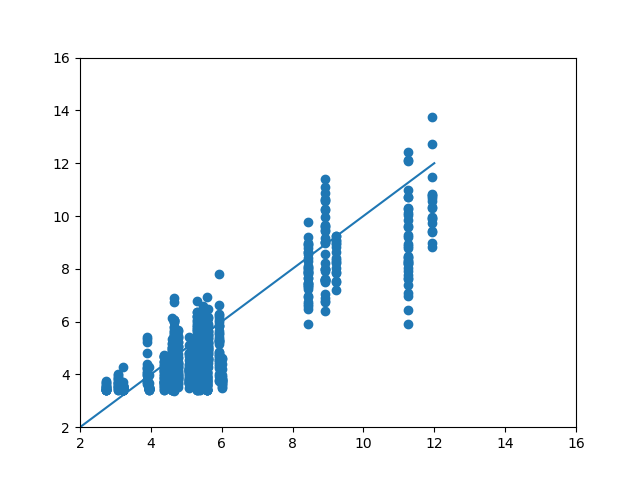

In [64]:
%matplotlib widget
plot_against(best_model, data_preparation(im_test), label_test)

In [66]:
save_path = os.path.join(storage_path, "models", "model_vendredi")
best_model.save(save_path)

2022-08-12 16:34:00.585513: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /media/kahane/AMFtopology02/storage/models/model_vendredi/assets
2022-08-12 16:34:02,605-[INFO]- tensorflow:779 -> Assets written to: /media/kahane/AMFtopology02/storage/models/model_vendredi/assets


In [38]:
best_model.evaluate(test_feature, test_label)

3/3 [==============================] - 0s 6ms/step - loss: 2.2786 - mean_absolute_error: 1.0133


[2.278571844100952, 1.0132561922073364]

In [39]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 1)]          0         
                                                                 
 rescaling (Rescaling)       (None, 120, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 111, 160)          1760      
                                                                 
 re_lu (ReLU)                (None, 111, 160)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 102, 128)          204928    
                                                                 
 re_lu_1 (ReLU)              (None, 102, 128)          0         
                                                                 
 average_pooling1d (AverageP  (None, 51, 128)          0     

In [40]:
tuner.get_best_models(5)

2022-06-07 15:53:58,773-[WARNING]- tensorflow:185 -> Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
2022-06-07 15:53:58,774-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.iter
2022-06-07 15:53:58,775-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_1
2022-06-07 15:53:58,777-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_2
2022-06-07 15:53:58,778-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.decay
2022-06-07 15:53:58,779-[WARNI

### Evaluate with data augmentation

In [49]:
from amftrack.ml.width.data_augmentation import *

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(120, 1)),
        random_crop(120),
        # random_invert(p=0.5),  # TODO(FK): keep?
        random_mirror(p=0.5),
        random_brightness(20),
    ]
)

In [50]:
data_preparation

In [42]:
test_feature

Array([[199, 198, 197, ..., 203, 204, 207],
       [175, 177, 176, ..., 167, 166, 166],
       [194, 194, 194, ..., 146, 134, 120],
       ...,
       [186, 186, 186, ..., 179, 177, 179],
       [204, 206, 206, ..., 205, 206, 206],
       [188, 189, 188, ..., 174, 177, 179]], dtype=uint8)

In [44]:
test_label.shape

(74, 1)

In [45]:
test_feature_ = data_augmentation(test_feature)

TensorShape([1, 80, 1])

In [ ]:
best_model.evaluate(test_feature, test_label)

In [41]:
data_augmentation

## BROUILLON

In [276]:
e

(<tf.Tensor: shape=(32, 80, 1), dtype=float32, numpy=
 array([[[130.],
         [130.],
         [130.],
         ...,
         [127.],
         [128.],
         [129.]],
 
        [[113.],
         [111.],
         [109.],
         ...,
         [129.],
         [128.],
         [125.]],
 
        [[119.],
         [120.],
         [120.],
         ...,
         [122.],
         [123.],
         [122.]],
 
        ...,
 
        [[146.],
         [144.],
         [141.],
         ...,
         [148.],
         [147.],
         [147.]],
 
        [[110.],
         [107.],
         [106.],
         ...,
         [116.],
         [115.],
         [114.]],
 
        [[124.],
         [124.],
         [124.],
         ...,
         [124.],
         [123.],
         [123.]]], dtype=float32)>,
 <tf.Tensor: shape=(32,), dtype=float64, numpy=
 array([7.26221294, 5.93755418, 5.5774322 , 4.19787153, 3.7441611 ,
        5.20109506, 4.87914297, 0.        , 8.52101685, 8.73503977,
        4.5910988

TEST 1

In [125]:
data_augmentation(train_feature).shape

TensorShape([527, 80, 1])

TEST 2

In [186]:
data_augmentation(train_feature)[:3,:3]

<tf.Tensor: shape=(3, 3, 1), dtype=float32, numpy=
array([[[131.],
        [130.],
        [129.]],

       [[130.],
        [130.],
        [128.]],

       [[130.],
        [131.],
        [131.]]], dtype=float32)>

TEST 3

In [187]:
help(tuner.search)

Help on method search in module keras_tuner.engine.base_tuner:

search(*fit_args, **fit_kwargs) method of keras_tuner.tuners.randomsearch.RandomSearch instance
    Performs a search for best hyperparameter configuations.
    
    Args:
        *fit_args: Positional arguments that should be passed to
          `run_trial`, for example the training and validation data.
        **fit_kwargs: Keyword arguments that should be passed to
          `run_trial`, for example the training and validation data.



TEST 4: making an augmented dataset from the tensor

In [188]:
help(tf.data.Dataset)

Help on class DatasetV2 in module tensorflow.python.data.ops.dataset_ops:

class DatasetV2(collections.abc.Iterable, tensorflow.python.training.tracking.base.Trackable, tensorflow.python.framework.composite_tensor.CompositeTensor)
 |  DatasetV2(variant_tensor)
 |  
 |  Represents a potentially large set of elements.
 |  
 |  The `tf.data.Dataset` API supports writing descriptive and efficient input
 |  pipelines. `Dataset` usage follows a common pattern:
 |  
 |  1. Create a source dataset from your input data.
 |  2. Apply dataset transformations to preprocess the data.
 |  3. Iterate over the dataset and process the elements.
 |  
 |  Iteration happens in a streaming fashion, so the full dataset does not need to
 |  fit into memory.
 |  
 |  Source Datasets:
 |  
 |  The simplest way to create a dataset is to create it from a python `list`:
 |  
 |  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
 |  >>> for element in dataset:
 |  ...   print(element)
 |  tf.Tensor(1, sh

In [ ]:
  file_path_features = [data_path_from_slice_path(path) for path in file_paths]

    both_path = tf.data.Dataset.from_tensor_slices(
        [list(couple) for couple in zip(file_paths, file_path_features)]
    )
    general_dataset = both_path.interleave(single_slice_dataset, cycle_length=n_readers)
    general_dataset = general_dataset.shuffle(shuffle_buffer_size).repeat(repeat)
    return general_dataset.batch(1)  # Output shape: (1, 120, 1)
    # TODO(FK): remove the batching here and the prefetch  .prefetch(1)

In [197]:
train_feature.shape

(527, 120)

In [219]:
prov = np.expand_dims(train_feature[4,:], axis=0)

In [220]:
prov.shape

(1, 120)

In [236]:
prov = np.expand_dims(train_feature[4,:], axis=-1)
prov = np.expand_dims(prov, axis=0)
prov.shape

(1, 120, 1)

In [143]:
def random_crop(output_size):
    # TODO(FK): add name
    # TODO(FK): handle size
    size = [74, output_size, 1]
    return tf.keras.layers.Lambda(lambda x: tf.image.random_crop(x, size=size))


@tf.function
def center_crop_slice(x, margin):
    return x[..., margin:-margin, :]


def center_crop(input_size=120, output_size=80):
    return tf.keras.layers.Lambda(
        lambda x: center_crop_slice(x, (input_size - output_size) // 2)
    )


data_augmentation = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(120, 1)),
        random_crop(80),
        # random_invert(p=0.5),  # TODO(FK): keep?
        #random_mirror(p=0.5),
        #random_brightness(10),
    ]
)

In [100]:
from amftrack.ml.width.data_augmentation import *

In [79]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(120, 1)),
        random_crop(80),
    ]
)

In [132]:
test_feature

Array([[199, 198, 197, ..., 203, 204, 207],
       [175, 177, 176, ..., 167, 166, 166],
       [194, 194, 194, ..., 146, 134, 120],
       ...,
       [186, 186, 186, ..., 179, 177, 179],
       [204, 206, 206, ..., 205, 206, 206],
       [188, 189, 188, ..., 174, 177, 179]], dtype=uint8)

In [144]:
feature_vector = data_augmentation(test_feature)

In [145]:
tf.random.set_seed(12)

In [146]:
feature_vector[:, 0, 0]

<tf.Tensor: shape=(74,), dtype=float32, numpy=
array([196., 166., 188., 186., 162., 200., 198., 157., 201., 180., 194.,
       188., 184., 189., 183., 180., 165., 155., 202., 171., 171., 203.,
       186., 173., 206., 176., 161., 200., 187., 175., 177., 194., 184.,
       181., 189., 194., 197., 194., 193., 200., 165., 183., 197., 205.,
       191., 155., 167., 168., 182., 178., 185., 192., 198., 158., 196.,
       168., 199., 177., 196., 203., 164., 193., 174., 189., 178., 197.,
       178., 202., 126., 175., 146., 170., 209., 186.], dtype=float32)>

In [147]:
feature_vector[:, 0, 0]

<tf.Tensor: shape=(74,), dtype=float32, numpy=
array([196., 166., 188., 186., 162., 200., 198., 157., 201., 180., 194.,
       188., 184., 189., 183., 180., 165., 155., 202., 171., 171., 203.,
       186., 173., 206., 176., 161., 200., 187., 175., 177., 194., 184.,
       181., 189., 194., 197., 194., 193., 200., 165., 183., 197., 205.,
       191., 155., 167., 168., 182., 178., 185., 192., 198., 158., 196.,
       168., 199., 177., 196., 203., 164., 193., 174., 189., 178., 197.,
       178., 202., 126., 175., 146., 170., 209., 186.], dtype=float32)>

In [148]:
best_model.evaluate(feature_vector, test_label)

3/3 [==============================] - 0s 1ms/step - loss: 5.2993 - mean_absolute_error: 1.2498


[5.299310207366943, 1.2498197555541992]

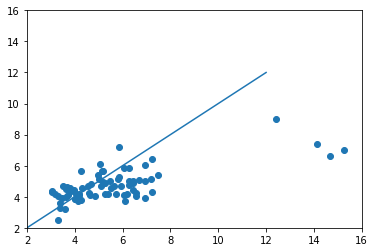

In [149]:
plot_against(best_model, feature_vector, test_label)

In [237]:
data_augmentation(prov)

<tf.Tensor: shape=(1, 80, 1), dtype=float32, numpy=
array([[[117.],
        [115.],
        [116.],
        [117.],
        [118.],
        [117.],
        [118.],
        [119.],
        [118.],
        [120.],
        [123.],
        [123.],
        [124.],
        [125.],
        [126.],
        [127.],
        [131.],
        [130.],
        [131.],
        [136.],
        [138.],
        [140.],
        [145.],
        [156.],
        [163.],
        [160.],
        [152.],
        [140.],
        [132.],
        [131.],
        [126.],
        [124.],
        [124.],
        [123.],
        [122.],
        [118.],
        [119.],
        [121.],
        [124.],
        [125.],
        [121.],
        [122.],
        [122.],
        [121.],
        [121.],
        [120.],
        [118.],
        [119.],
        [120.],
        [119.],
        [116.],
        [118.],
        [118.],
        [117.],
        [118.],
        [119.],
        [119.],
        [117.],
        [115.],
    

In [200]:
train_feature[5,:].shape

(120,)

In [205]:
type(train_label[1])

numpy.ndarray

In [207]:
type(np.array(train_feature[6,:]))

numpy.ndarray

In [209]:
len(train_feature)

527

In [210]:
both_path = tf.data.Dataset.from_tensor_slices(
        [list(couple) for couple in zip([np.array(train_feature[i,:]) for i in range(len(train_feature))], train_label)]
    )

ValueError: Can't convert non-rectangular Python sequence to Tensor.

In [232]:
train_feature.shape

(527, 120)

In [233]:
data_augmentation(train_feature).shape

TensorShape([527, 80, 1])

In [233]:
data_augmentation(train_feature).shape

TensorShape([527, 80, 1])

In [230]:
d1 = tf.data.Dataset.from_tensor_slices(train_feature)
d1_ = d1.map(lambda x: np.expand_dims(x, 0))

NotImplementedError: in user code:

    File "/tmp/ipykernel_21812/3081659417.py", line 2, in None  *
        lambda x: np.expand_dims(x, 0)
    File "<__array_function__ internals>", line 180, in expand_dims  **
        
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/numpy/lib/shape_base.py", line 591, in expand_dims
        a = asanyarray(a)

    NotImplementedError: Cannot convert a symbolic Tensor (args_0:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported


In [227]:
d2 = tf.data.Dataset.from_tensor_slices(train_label)
d3 = tf.data.Dataset.zip((d1, d2))

In [225]:
train = (
    d3.map(lambda x, y: (data_augmentation(x, training=True), y))
    .unbatch()
    .batch(BATCHSIZE)
    .prefetch(tf.data.AUTOTUNE)
)

2022-08-16 18:05:48,465-[WARNING]- tensorflow:665 -> Model was constructed with shape (None, 120, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 120, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (120,).


ValueError: in user code:

    File "/tmp/ipykernel_21812/1607789451.py", line 2, in None  *
        lambda x, y: (data_augmentation(x, training=True), y)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/home/felix/Wks/AMFtrack/amftrack/ml/width/data_augmentation.py", line 80, in <lambda>
        lambda x: random_crop_slice(x, original_size, input_size, offset),

    ValueError: Exception encountered when calling layer "random_crop_with_offset_0" (type Lambda).
    
    in user code:
    
        File "/home/felix/Wks/AMFtrack/amftrack/ml/width/data_augmentation.py", line 74, in random_crop_slice  *
            return x[..., start_index : start_index + input_size, :]
    
        ValueError: Index out of range using input dim 1; input has only 1 dims for '{{node strided_slice}} = StridedSlice[Index=DT_INT64, T=DT_FLOAT, begin_mask=4, ellipsis_mask=1, end_mask=4, new_axis_mask=0, shrink_axis_mask=0](x, strided_slice/stack, strided_slice/stack_1, strided_slice/Cast)' with input shapes: [120], [3], [3], [3] and with computed input tensors: input[3] = <1 1 1>.
    
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(120,), dtype=float32)
      • mask=None
      • training=True


## BROUILLON

In [66]:
train_feature.shape

(377, 120)

In [77]:
prov = np.expand_dims(train_feature, axis=-1).shape

In [79]:
help(tf.data.Dataset.from_tensor_slices)

Help on function from_tensor_slices in module tensorflow.python.data.ops.dataset_ops:

from_tensor_slices(tensors, name=None)
    Creates a `Dataset` whose elements are slices of the given tensors.
    
    The given tensors are sliced along their first dimension. This operation
    preserves the structure of the input tensors, removing the first dimension
    of each tensor and using it as the dataset dimension. All input tensors
    must have the same size in their first dimensions.
    
    >>> # Slicing a 1D tensor produces scalar tensor elements.
    >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
    >>> list(dataset.as_numpy_iterator())
    [1, 2, 3]
    
    >>> # Slicing a 2D tensor produces 1D tensor elements.
    >>> dataset = tf.data.Dataset.from_tensor_slices([[1, 2], [3, 4]])
    >>> list(dataset.as_numpy_iterator())
    [array([1, 2], dtype=int32), array([3, 4], dtype=int32)]
    
    >>> # Slicing a tuple of 1D tensors produces tuple elements containing
    

In [78]:
train_ds = tf.data.Dataset.from_tensor_slices(prov)

ValueError: Unbatching a tensor is only supported for rank >= 1

In [69]:
for e in train_ds:
    print(e.shape)

(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(

In [65]:
data_preparation(train_feature).shape

TensorShape([377, 80, 1])

In [62]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_feature)
train_dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(120,), dtype=tf.uint8, name=None)>

In [57]:
train = (
    train_dataset.map(lambda x: (data_augmentation(x, training=True)))
    .unbatch()
    .batch(BATCHSIZE)
    .prefetch(tf.data.AUTOTUNE)
)

2022-08-16 16:51:06,205-[WARNING]- tensorflow:665 -> Model was constructed with shape (None, 120, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 120, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (120,).


ValueError: in user code:

    File "/tmp/ipykernel_21812/1439737797.py", line 2, in None  *
        lambda x: (data_augmentation(x, training=True))
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/home/felix/Wks/AMFtrack/amftrack/ml/width/data_augmentation.py", line 80, in <lambda>
        lambda x: random_crop_slice(x, original_size, input_size, offset),

    ValueError: Exception encountered when calling layer "random_crop_with_offset_0" (type Lambda).
    
    in user code:
    
        File "/home/felix/Wks/AMFtrack/amftrack/ml/width/data_augmentation.py", line 74, in random_crop_slice  *
            return x[..., start_index : start_index + input_size, :]
    
        ValueError: Index out of range using input dim 1; input has only 1 dims for '{{node strided_slice}} = StridedSlice[Index=DT_INT64, T=DT_FLOAT, begin_mask=4, ellipsis_mask=1, end_mask=4, new_axis_mask=0, shrink_axis_mask=0](x, strided_slice/stack, strided_slice/stack_1, strided_slice/Cast)' with input shapes: [120], [3], [3], [3] and with computed input tensors: input[3] = <1 1 1>.
    
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(120,), dtype=float32)
      • mask=None
      • training=True


In [55]:
train_dataset = (
        train_dataset.map(data_augmentation)
        .unbatch()
        .batch(BATCHSIZE)
        .prefetch(tf.data.AUTOTUNE)
    )

2022-08-16 16:49:36,925-[WARNING]- tensorflow:665 -> Model was constructed with shape (None, 120, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 120, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (120,).


ValueError: Exception encountered when calling layer "random_crop_with_offset_0" (type Lambda).

in user code:

    File "/home/felix/Wks/AMFtrack/amftrack/ml/width/data_augmentation.py", line 74, in random_crop_slice  *
        return x[..., start_index : start_index + input_size, :]

    ValueError: Index out of range using input dim 1; input has only 1 dims for '{{node strided_slice}} = StridedSlice[Index=DT_INT64, T=DT_FLOAT, begin_mask=4, ellipsis_mask=1, end_mask=4, new_axis_mask=0, shrink_axis_mask=0](x, strided_slice/stack, strided_slice/stack_1, strided_slice/Cast)' with input shapes: [120], [3], [3], [3] and with computed input tensors: input[3] = <1 1 1>.


Call arguments received:
  • inputs=tf.Tensor(shape=(120,), dtype=float32)
  • mask=None
  • training=False